# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *

In [2]:
from typing import List, Optional, Union
import json
import time

In [3]:
#from datalore.display import *

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
def to_scalar(x, i):
    """Returns i-th element from an array x if x is array, else returns x
Args:
    x - input array
    i - index to return
Returns:
    x[i] if x is an array and x else
"""
    if isinstance(x, (np.ndarray, list)):
        return x[i]
    return x

In [6]:
def gradient_checker(J, grad_J, theta, eps=1e-4, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index

        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        np.random.seed(42)
        J1 = J(theta_)

        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        np.random.seed(42)
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J(theta))[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J(theta)[ix])))

        if np.all(rel_tol > rtol):
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [7]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    previous = model.parameters()[idx].copy()
    np.copyto(dst=model.parameters()[idx], src=theta)
    outputs = model(x)
    loss = loss_function(outputs, y)
    np.copyto(dst=model.parameters()[idx], src=previous)
    return loss

In [8]:
def dJ_theta_global(model, loss_function, theta, idx, x):
    grad = model.backward(loss_function)[idx] / x.shape[0]
    return grad.reshape(theta.shape)

In [9]:
def sigmoid(x,slope=1.0):
    return 1.0/(1.0+np.exp(-slope*x))

In [10]:
def sigmoid_prime(x,slope=1.0):
    return slope*sigmoid(x,slope=slope)*(1.0-sigmoid(x,slope=slope))

In [11]:
z = np.random.normal(size=5)
gradient_checker(sigmoid, sigmoid_prime, z, eps=1e-4, rtol=1e-5)

Gradient check passed


In [12]:
def plot_digit(digit, size=8, caption=None):
    digit = digit.reshape(size, size)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p;

In [13]:
def gg_confusion_matrix(y, y_hat):
    conf_mat = confusion_matrix(y, y_hat)[::-1]
    confusion_dat = pd.DataFrame(conf_mat)
    observed = confusion_dat.columns.values
    actual = confusion_dat.index.values
    xx, yy = np.meshgrid(actual, observed)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = conf_mat.reshape(-1)
    dat = {'predicted':xx, 'actual':yy[::-1], 'z':zz}
    p = ggplot(dat, aes('predicted', 'actual', fill='z')) \
        + geom_raster() \
        + geom_text(aes(label='z'), color='white')\
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank')\
        + ggsize(500, 500) + scale_x_discrete() + scale_y_discrete()\
        + ggtitle('Confusion matrix')
    return p

In [14]:
def f1_score_micro(conf_matrix):
    num_tags = conf_matrix.shape[0]
    score = 0.
    pr, p, r = 0., 0., 0.
    for tag in range(num_tags):
        pr += conf_matrix[tag, tag]
        p += sum(conf_matrix[tag, :])
        r += sum(conf_matrix[:, tag])
    try:
        score = 2 * pr / (p + r)
    except ZeroDivisionError:
        pass
    return score

In [15]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [16]:
import matplotlib.ticker as ticker

In [17]:
import itertools

In [18]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap: str='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN
    
    fig: Figure = Figure(figsize=(7, 7))
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.matshow(norm_cm, cmap=cmap)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(False)
    plt.tight_layout()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
                horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

In [19]:
class Function:
    def __call__(self) -> "Tensor":
        pass
    
    def backward(self, *args, **kwargs):
        pass

In [20]:
class Tensor:
    def __init__(self, data: np.ndarray, func: Optional[Function]=None, name: str=None):
        self.data: np.ndarray = data
        self.grad: np.ndarray = np.zeros(data.shape)
        self.func = func
        self.__name__ = name
    
    def backward(self, grad: Optional[np.ndarray] = None):
        if grad is not None:
            assert grad.shape == self.grad.shape
            self.grad += grad
            if self.func:
                self.func.backward(grad)
        else:
            if self.func:
                self.func.backward()

    def zero_grad(self):
        self.grad[:] = .0
    
    def reshape(self, *args, **kwargs):
        return Tensor(self.data.reshape(*args, **kwargs), self.func, self.__name__)
    
    def transpose(self, *args, **kwargs):
        return Tensor(self.data.transpose(*args, **kwargs), self.func, self.__name__)
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def size(self):
        return self.data.size
    
    def astype(self, dtype: Union[str, np.dtype]):
        return self.data.astype(dtype)
    
    def __str__(self) -> str:
        return str(self.data)

In [21]:
class Module:
    def __init__(self):
        self.parameters: List[Tensor] = []
        self.__name__ = self.__class__.__name__
        self.state_dict = {}
        self.training = True
    
    @staticmethod
    def get_module_state_dict(module: "Module"):
        keys = [param.__name__ for param in module.__dict__['parameters']]
        values = [param.data.tolist() for param in module.__dict__['parameters']]
        return dict(zip(keys, values))
     
    def update_state_dict(self):
        module_state_dicts = []
        module_names = []
        for key in self.__dict__:
            value = self.__dict__[key]
            base_class_name = value.__class__.__bases__[0].__name__
            class_name = value.__class__.__name__
            if base_class_name == 'Module':
                class_has_parameters = hasattr(value, "parameters")
                if class_has_parameters:
                    parameters_not_empty = len(value.parameters) > 0
                    if parameters_not_empty:
                        module_names.append(key)
                        module_state_dict = self.get_module_state_dict(value)
                        module_state_dicts.append(module_state_dict)
        self.state_dict = dict(zip(module_names, module_state_dicts))

    def register_parameter(self, param: Tensor):
        self.parameters.append(param)

    def register_parameters(self, param_list_or_module: Union[List[Tensor], "Module", List["Module"]]):
        if isinstance(param_list_or_module, List):
            for element in param_list_or_module:
                if isinstance(element, Tensor):
                    self.register_parameter(element)
                elif isinstance(element, Module):
                    for param in element.parameters:
                        self.register_parameter(param)
                else:
                    raise TypeError("Parameter should be of type Tensor")
        elif isinstance(param_list_or_module, Module):
            for param in param_list_or_module.parameters:
                self.register_parameter(param)
        self.update_state_dict()
    
    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def size(self):
        s = 0
        for param in self.parameters:
            s += param.data.size
        return s
    
    def update_parameters_from_state_dict(self):
        for key in self.__dict__:
            if key in self.state_dict:
                for param in self.__dict__[key].parameters:
                    param.data = np.asarray(self.state_dict[key][param.__name__])

    def save(self, filename: str = None):
        if filename is None:
            filename = time.strftime("%Y%m%d-%H%M%S") + '.json'
        self.update_state_dict()
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.state_dict, f, ensure_ascii=False, indent=4)
    
    def load(self, filename: str):
        with open(filename, 'r') as f:
            json_str = f.read()
            self.state_dict = json.loads(json_str)
        self.update_parameters_from_state_dict()
    
    def train(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = True
    
    def eval(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = False

In [22]:
class Optimizer:
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        self.params = params
        self.lr = lr

    def step(self, *args, **kwargs):
        raise NotImplemented
    
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [23]:
def plot_conv_layer(W, n_col=5, width=70, size=3):
    col, row = 0, 0
    height = width
    step = width + 0
    bunch = GGBunch()
    for img in W:
        if col == n_col:
            col = 0
            row += 1
        img = img.squeeze()
        plot = plot_digit(img, size) + ggsize(width, width)
        bunch.add_plot(plot, x0 + col*step, y0 + row*step, width, height)
        col += 1
    bunch.show()

# Adam

### Copy your Adam implementation from second homework here.

In [24]:
class Scheduler:
    def __init__(self, optimizer: Optimizer, last_epoch: int = -1):
        self.optimizer = optimizer
        self.base_lr = optimizer.lr
        self.last_epoch = last_epoch
    
    def step(self):
        raise NotImplementedError

In [25]:
class FixedScheduler(Scheduler):
    def __init__(self, eta):
        self.eta = eta
    def step(self):
        return self.eta

In [26]:
class Adam(Optimizer):
    def __init__(self, params, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01, eta=0.01):
        super().__init__(params)
        self.lr = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.sheduler = FixedScheduler(eta)
        self.weight_decay = weight_decay
        self.m = [np.zeros(param.data.shape) for param in params]
        self.v = [np.zeros(param.data.shape) for param in params]
        self.t = 0

    def step(self, eta=None):
        eta = self.sheduler.step()
        self.t += 1
        for i, param in enumerate(self.params):
            g = param.grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta1 * self.v[i] + (1 - self.beta2) * g ** 2
            m = self.m[i] / (1 - self.beta1**self.t)
            v = self.v[i] / (1 - self.beta2**self.t)
            param.data -= eta * (self.lr * m /(np.sqrt(v) + self.eps) + self.weight_decay * param.data)

# CNN

### Problem 1 starter code

You can find here the starter code for the Convolutional Neural Network tasks.

In [27]:
from numpy.lib import stride_tricks

In [28]:
from sklearn.datasets import load_digits

In [29]:
from typing import List, Optional, Union
import json
import time

In [30]:
digits_bunch = load_digits()
digits_df = pd.DataFrame(digits_bunch.data)
digits_df['target'] = pd.Series(pd.Categorical.from_codes(digits_bunch.target, categories=digits_bunch.target_names))

In [31]:
X, y = digits_df.drop('target', axis=1), digits_df['target']
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

X shape: (1797, 64), y shape: (1797,)


In [32]:
X, y = X.values, y.values
y = y.astype(int)
X = X / 16

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (1149, 64), X_val shape: (288, 64), X_test shape: (360, 64)


In [34]:
random_ind = np.random.randint(low=0, high=X.shape[0], size=100)
digit_examples = X[random_ind]

In [35]:
bunch = GGBunch()
x0, y0 = 0, 0
row = 0
col = 0
width = 50
height = width
step = width + 0
n_cols = 10
for digit in digit_examples:
    if col == n_cols:
        col = 0
        row += 1
    plot = plot_digit(digit)
    bunch.add_plot(plot, x0 + col*step, y0 + row*step, width, height)
    col += 1
bunch.show()

In [36]:
def im2col_idx(x, Hf, Wf, padding=1, stride=1):
    Nx, Cx, Hx, Wx = x.shape

    Hx += 2 * padding
    Wx += 2 * padding
    Ho = (Hx - Hf) / stride + 1
    Wo = (Wx - Wf) / stride + 1
    Ho, Wo = int(Ho), int(Wo)

    mask = np.arange(Nx * Cx * Hx * Wx).reshape(Nx, Cx, Hx, Wx)
    shape = (Cx, Hf, Wf, Nx, Ho, Wo)
    strides = (Hx * Wx, Wx, 1, Cx * Hx * Wx, stride * Wx, stride)
    strides = x.itemsize * np.array(strides)
    mask_stride = stride_tricks.as_strided(mask, shape=shape, strides=strides, writeable=False)
    return mask_stride, Ho, Wo

In [37]:
def im2col(x, Hf, Wf, padding=1, stride=1):
    Nx, Cx, Hx, Wx = x.shape

    x_padded = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    mask_stride, Ho, Wo = im2col_idx(x, Hf, Wf, padding, stride)

    idx = mask_stride.ravel()
    x_padded_stride = x_padded.ravel()[idx].reshape(mask_stride.shape)
    cols = np.ascontiguousarray(x_padded_stride)

    cols = np.ascontiguousarray(cols.transpose(0, 1, 2, 4, 5, 3))
    cols.shape = (Cx * Hf * Wf, Ho * Wo * Nx)
    return cols

In [38]:
def col2im(cols, x, Hf, Wf, padding=1, stride=1):
    Nx, Cx, Hx, Wx = x.shape
    Hp, Wp = Hx + 2 * padding, Wx + 2 * padding
    x_padded = np.zeros((Nx, Cx, Hp, Wp), dtype=cols.dtype)
    x_padded = np.ascontiguousarray(x_padded)
    mask_stride, Ho, Wo = im2col_idx(x, Hf, Wf, padding, stride)

    cols_reshaped = cols.reshape(Cx * Hf * Wf, Ho, Wo, Nx).transpose(0, 3, 1, 2)
    cols_reshaped = cols_reshaped.reshape(Cx * Hf * Wf, -1, Nx)

    np.add.at(x_padded.ravel(), mask_stride.ravel(), cols_reshaped.ravel())
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [39]:
class Function:
    def __call__(self) -> "Tensor":
        pass
    
    def backward(self, *args, **kwargs):
        pass

In [40]:
class Tensor:
    def __init__(self, data: np.ndarray, func: Optional[Function]=None, name: str=None):
        self.data: np.ndarray = data
        self.grad: np.ndarray = np.zeros(data.shape)
        self.func = func
        self.__name__ = name
    
    def backward(self, grad: Optional[np.ndarray] = None):
        if grad is not None:
            assert grad.shape == self.grad.shape
            self.grad += grad
            if self.func:
                self.func.backward(grad)
        else:
            if self.func:
                self.func.backward()

    def zero_grad(self):
        self.grad[:] = .0
    
    def reshape(self, *args, **kwargs):
        return Tensor(self.data.reshape(*args, **kwargs), self.func, self.__name__)
    
    def transpose(self, *args, **kwargs):
        return Tensor(self.data.transpose(*args, **kwargs), self.func, self.__name__)
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def size(self):
        return self.data.size
    
    def astype(self, dtype: Union[str, np.dtype]):
        return self.data.astype(dtype)
    
    def __str__(self) -> str:
        return str(self.data)

In [41]:
class Module:
    def __init__(self):
        self.parameters: List[Tensor] = []
        self.__name__ = self.__class__.__name__
        self.state_dict = {}
        self.training = True
    
    @staticmethod
    def get_module_state_dict(module: "Module"):
        keys = [param.__name__ for param in module.__dict__['parameters']]
        values = [param.data.tolist() for param in module.__dict__['parameters']]
        return dict(zip(keys, values))
     
    def update_state_dict(self):
        module_state_dicts = []
        module_names = []
        for key in self.__dict__:
            value = self.__dict__[key]
            base_class_name = value.__class__.__bases__[0].__name__
            class_name = value.__class__.__name__
            if base_class_name == 'Module':
                class_has_parameters = hasattr(value, "parameters")
                if class_has_parameters:
                    parameters_not_empty = len(value.parameters) > 0
                    if parameters_not_empty:
                        module_names.append(key)
                        module_state_dict = self.get_module_state_dict(value)
                        module_state_dicts.append(module_state_dict)
        self.state_dict = dict(zip(module_names, module_state_dicts))

    def register_parameter(self, param: Tensor):
        self.parameters.append(param)

    def register_parameters(self, param_list_or_module: Union[List[Tensor], "Module", List["Module"]]):
        if isinstance(param_list_or_module, List):
            for element in param_list_or_module:
                if isinstance(element, Tensor):
                    self.register_parameter(element)
                elif isinstance(element, Module):
                    for param in element.parameters:
                        self.register_parameter(param)
                else:
                    raise TypeError("Parameter should be of type Tensor")
        elif isinstance(param_list_or_module, Module):
            for param in param_list_or_module.parameters:
                self.register_parameter(param)
        self.update_state_dict()
    
    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def size(self):
        s = 0
        for param in self.parameters:
            s += param.data.size
        return s
    
    def update_parameters_from_state_dict(self):
        for key in self.__dict__:
            if key in self.state_dict:
                for param in self.__dict__[key].parameters:
                    param.data = np.asarray(self.state_dict[key][param.__name__])

    def save(self, filename: str = None):
        if filename is None:
            filename = time.strftime("%Y%m%d-%H%M%S") + '.json'
        self.update_state_dict()
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.state_dict, f, ensure_ascii=False, indent=4)
    
    def load(self, filename: str):
        with open(filename, 'r') as f:
            json_str = f.read()
            self.state_dict = json.loads(json_str)
        self.update_parameters_from_state_dict()
    
    def train(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = True
    
    def eval(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = False

In [42]:
def Wandb(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return Tensor(W, name='weights'), Tensor(b, name='bias')

In [43]:
class Linear(Function):
    def __init__(self, x: Tensor, W: Tensor, b: Tensor):
        self.x = x
        self.W = W
        self.b = b

    def __call__(self):
        outputs = np.dot(self.x.data, self.W.data) + self.b.data
        return Tensor(outputs, func=self)

    def backward(self, grad: np.ndarray):
        dW = np.dot(self.x.data.T, grad)
        db = grad.sum(axis=0)
        dx = np.dot(grad, self.W.data.T)
        self.W.backward(dW.reshape(self.W.shape))
        self.b.backward(db.reshape(self.b.shape))
        self.x.backward(dx.reshape(self.x.shape))
        

In [44]:
class LinearLayer(Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.W, self.b = Wandb(in_dim, out_dim)
        self.register_parameters([self.W, self.b])
        self.x = None

    def forward(self, x: Tensor):
        return Linear(x, self.W, self.b)()

In [45]:
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

In [46]:
class Sigmoid(Function):
    def __init__(self, x: Tensor):
        self.x = x

    def __call__(self):
        self.a = sigmoid(self.x.data)
        return Tensor(self.a, self)

    def backward(self, grad: np.ndarray):
        grad = self.a * (1. - self.a) * grad.reshape(self.a.shape)
        self.x.backward(grad)

In [47]:
class SigmoidFunction(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return Sigmoid(x)()

In [48]:
def softmax(x: Tensor):
    a = np.amax(x.data, axis=1)[:, np.newaxis]
    ex = np.exp(x.data - a)
    ex_sum = np.sum(ex, axis=1)[:, np.newaxis]
    out = ex / ex_sum
    return Tensor(out, x.func)

In [49]:
def one_hot_encoder(labels: Tensor, n_classes=10):
    encoded = np.zeros((labels.size, n_classes))
    encoded[np.arange(labels.size), labels.astype(int)] = 1
    return Tensor(encoded)

In [50]:
class NLL(Function):
    def __init__(self, y_hat: Tensor, y: Tensor, eps: float = 1e-15):
        self.y_hat = softmax(y_hat)
        self.y = one_hot_encoder(y)
        self.eps = eps

    def __call__(self):
        logs = np.log(self.y_hat.data + self.eps)
        loss = np.multiply(-self.y.data, logs).sum(axis=1).sum()
        return Tensor(loss, self)
    
    def backward(self):
        grad = self.y_hat.data - self.y.data
        self.y_hat.backward(grad)

In [51]:
class CrossEntropyLoss(Module):
    def __init__(self, eps=1e-15):
        super().__init__()
        self.eps = eps

    def forward(self, output, target):
        return NLL(output, target, self.eps)()

In [52]:
class Optimizer:
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        self.params = params
        self.lr = lr

    def step(self, *args, **kwargs):
        raise NotImplemented
    
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [53]:
class SGD(Optimizer):
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        super().__init__(params, lr)

    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

In [54]:
class Scheduler:
    def __init__(self, optimizer: Optimizer, last_epoch: int = -1):
        self.optimizer = optimizer
        self.base_lr = optimizer.lr
        self.last_epoch = last_epoch
    
    def step(self):
        raise NotImplementedError

In [55]:
class ConstantLR(Scheduler):
    def __init__(self, optimizer: Optimizer):
        super().__init__(optimizer)
        self.lr = optimizer.lr
    
    def step(self):
        self.last_epoch += 1

In [56]:
def xavier_(weights):
    for weight in weights:
        in_dim, out_dim = weight.shape[-2:]
        np.copyto(dst=weight.data, src=np.random.randn(*weight.shape) * np.sqrt(2. / (in_dim + out_dim)))

In [57]:
class Conv2D(Function):
    def __init__(self, x: Tensor, W: Tensor, b: Tensor = None, stride: int = 1, padding: int = 1):
        self.x = x
        self.W = W
        self.b = b
        self.stride = stride
        self.padding = padding

    def __call__(self):
        Nf, Cf, Hf, Wf = self.W.shape
        Nx, Cx, Hx, Wx = self.x.shape

        Ho = (Hx - Hf + 2 * self.padding) / self.stride + 1
        Wo = (Wx - Wf + 2 * self.padding) / self.stride + 1
        Ho, Wo = int(Ho), int(Wo)

        self.x_col = im2col(self.x.data, Hf, Wf, self.padding, self.stride)

        self.x_col = np.ascontiguousarray(self.x_col)
        W_col = self.W.data.reshape(Nf, -1)
        z = np.dot(W_col, self.x_col) + self.b.data
        z = z.reshape(Nf, Ho, Wo, Nx)
        z = z.transpose(3, 0, 1, 2)
        z = np.ascontiguousarray(z)
        return Tensor(z, func=self)

    def backward(self, grad:np.ndarray):
        Nf, Cf, Hf, Wf = self.W.shape

        db = grad.sum(axis=(0, 2, 3))
        db = db.reshape(Nf, -1)

        grad_ = grad.transpose(1, 2, 3, 0).reshape(Nf, -1)
        dW = np.dot(grad_, self.x_col.T)
        dW = dW.reshape(self.W.shape)

        W_ = self.W.data.reshape(Nf, -1)
        dx_col = np.dot(W_.T, grad_)
        dx_col = np.ascontiguousarray(dx_col)
        dx = col2im(dx_col, self.x.data, Hf, Wf, self.padding, self.stride)
        dx = np.ascontiguousarray(dx)
        self.W.backward(dW.reshape(self.W.shape))
        self.b.backward(db.reshape(self.b.shape))
        self.x.backward(dx.reshape(self.x.shape))

In [58]:
class ConvLayer(Module):
    def __init__(self, N, C, H=3, W=3, stride=1, padding=1):
        super().__init__()
        self.W = Tensor(np.random.randn(N, C, H, W) * 0.01, name='weights')
        self.b = Tensor(np.random.randn(N, 1), name='bias')
        self.stride = stride
        self.padding = padding
        self.register_parameters([self.W, self.b])
        self.x = None

    def forward(self, x: Tensor):
        return Conv2D(x, self.W, self.b, self.stride, self.padding)()

In [59]:
class ConvNetwork(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(10, 1)
        self.conv2 = ConvLayer(3, 10)
        self.fc = LinearLayer(192, 10)
        self.sigmoid1 = SigmoidFunction()
        self.sigmoid2 = SigmoidFunction()

        xavier_(self.conv1.parameters)
        xavier_(self.conv2.parameters)
        xavier_(self.fc.parameters)
        self.register_parameters([self.conv1, self.conv2, self.fc])

    def forward(self, x: Tensor):
        z1 = self.conv1(x)
        a1 = self.sigmoid1(z1)
        z2 = self.conv2(a1)
        a2 = self.sigmoid2(z2)
        flat = a2.reshape(a2.shape[0], -1)
        z3 = self.fc(flat)
        return z3

In [60]:
def reshape(x: Tensor, Nx=10, Cx=1, Hx=8, Wx=8):
    return x.reshape(-1, Cx, Hx, Wx)

In [61]:
class DataLoader:
    def __init__(self, data, target, batch_size=20):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m, replace=False)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield Tensor(X_batch), Tensor(y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

In [62]:
def eval_accuracy(model, val, y_val):
    was_training = model.training
    if was_training:
        model.eval()
    val = reshape(Tensor(val), 11200)
    output = model(val)
    y_hat = np.argmax(output.data, axis=1)
    if was_training:
        model.train()
    return accuracy_score(y_val, y_hat)

In [63]:
num_epochs = 50
batch_size = 10
dataloader = DataLoader(X_train, y_train, batch_size)
model = ConvNetwork()
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=0.01)
scheduler = ConstantLR(optimizer)

In [64]:
model.size()

2303

In [65]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        inputs = reshape(inputs)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, X_val, y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 48.37440609992467, acc: 0.9756944444444444

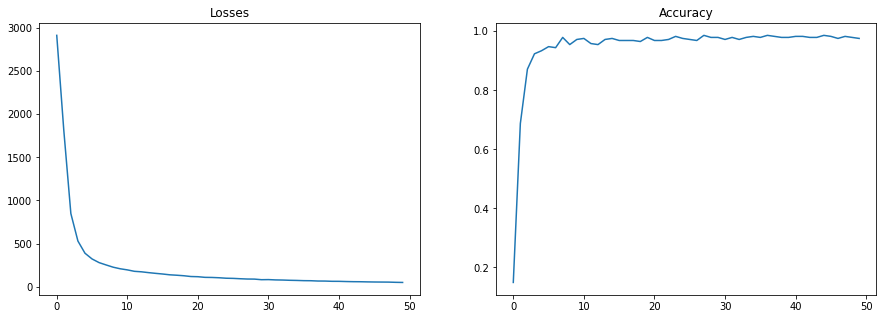

In [66]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

In [67]:
model.eval()
y_hat = model(reshape(Tensor(X_train)))
y_pred = np.argmax(y_hat.data, axis=1)

In [68]:
gg_confusion_matrix(y_train, y_pred) + ggsize(500, 500)

In [69]:
cm = confusion_matrix(y_train, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9956483899042646


In [70]:
model.eval()
y_hat = model(reshape(Tensor(X_test)))
y_pred = np.argmax(y_hat.data, axis=1)

In [71]:
gg_confusion_matrix(y_test, y_pred) + ggsize(500, 500)

In [72]:
cm = confusion_matrix(y_test, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9694444444444444


In [73]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [74]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    x = reshape(x)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [75]:
def dJ_theta_global(model, loss_function, x, y):
    x = reshape(x)
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [76]:
loss_function = CrossEntropyLoss()
model_ = ConvNetwork()
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start
Gradient check passed
[0]: Elapsed time: 4.1s
[1]: Start
Gradient check passed
[1]: Elapsed time: 0.5s
[2]: Start
Gradient check passed
[2]: Elapsed time: 12.2s
[3]: Start
Gradient check passed
[3]: Elapsed time: 0.1s
[4]: Start
Gradient check passed
[4]: Elapsed time: 87.2s
[5]: Start
Gradient check passed
[5]: Elapsed time: 0.4s
Total elapsed time: 104.5s


In [77]:
plot_conv_layer(model.conv1.W.data)

In [78]:
for W in model.conv2.W.data:
    plot_conv_layer(W)

# 1. MaxPool

### Problem 3 (6.0)
Implement the MaxPool layer. See the theory in the CS231n Stanford course: [http://cs231n.github.io/convolutional-networks/#pool](http://cs231n.github.io/convolutional-networks/#pool)
Actually it is similar to convolutional layer.

In [170]:
class MaxPool(Function):
    def __init__(self, x: Tensor, size: int, stride: int, padding: int):
        self.x = x
        self.size = size
        self.stride = stride
        self.padding = padding

    def __call__(self):
        Nx, Cx, Hx, Wx = self.x.shape
        #print(Nx, Cx, Hx, Wx)

        Ho = (Hx - self.size + 2 * self.padding) / self.stride + 1
        Wo = (Wx - self.size + 2 * self.padding) / self.stride + 1
        Ho, Wo = int(Ho), int(Wo)
        self.reshaped_data = self.x.data.reshape(Nx*Cx, 1, Hx, Wx) 
        self.x_col = im2col(self.reshaped_data, self.size, self.size, self.padding, self.stride)
        #print(self.x_col.shape)
        self.x_col = np.ascontiguousarray(self.x_col)

        z = self.x_col.max(axis=0)
        z = z.reshape(Ho, Wo, Nx, Cx)
        z = z.transpose(2, 3, 0, 1)
        return Tensor(z, func=self)


    def backward(self, grad: np.ndarray):
        dx_col = np.zeros_like(self.x_col)
        grad_flat = grad.transpose(2, 3, 0, 1).flatten()
        idx = np.argmax(self.x_col, axis=0)
        dx_col[idx, np.arange(len(idx))] = grad_flat
        dx = col2im(dx_col, self.reshaped_data, self.size, self.size, self.padding, self.stride)
        dx = np.ascontiguousarray(dx)
        self.x.backward(dx.reshape(self.x.shape))

In [171]:
class MaxPoolLayer(Module):
    def __init__(self, size: int, stride: int, padding: int):
        super().__init__()
        self.size = size
        self.stride = stride
        self.padding = padding
        self.x = None

    def forward(self, x: Tensor):
        return MaxPool(x, self.size, self.stride, self.padding)()

# Checks

In [172]:
class ConvNetwork(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(10, 1)
        self.pool = MaxPoolLayer(size=2, stride=2, padding=0)
        self.conv2 = ConvLayer(3, 10)
        self.fc = LinearLayer(48, 10)  # set correct in_dim here after setting pooling
        self.sigmoid1 = SigmoidFunction()
        self.sigmoid2 = SigmoidFunction()

        xavier_(self.conv1.parameters)
        xavier_(self.conv2.parameters)
        xavier_(self.fc.parameters)
        self.register_parameters([self.conv1, self.conv2, self.fc])

    def forward(self, x: Tensor):
        z1 = self.conv1(x)
        z1 = self.pool(z1)
        a1 = self.sigmoid1(z1)
        z2 = self.conv2(a1)
        a2 = self.sigmoid2(z2)
        flat = a2.reshape(a2.shape[0], -1)
        z3 = self.fc(flat)
        return z3

In [173]:
num_epochs = 50
batch_size = 10
dataloader = DataLoader(X_train, y_train, batch_size)
model = ConvNetwork()
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=0.01)
scheduler = ConstantLR(optimizer)

In [174]:
model.size()

863

In [175]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        inputs = reshape(inputs)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, X_val, y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 105.17969131253636, acc: 0.9548611111111112

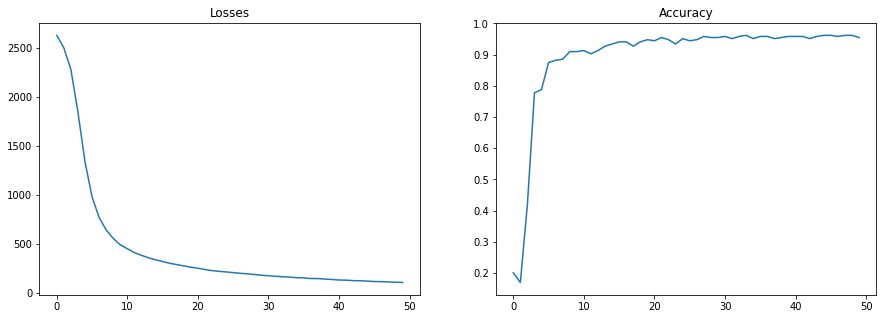

In [176]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

In [154]:
model.eval()
y_hat = model(reshape(Tensor(X_train)))
y_pred = np.argmax(y_hat.data, axis=1)

In [132]:
gg_confusion_matrix(y_train, y_pred) + ggsize(500, 500)

In [89]:
cm = confusion_matrix(y_train, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9956483899042646


In [90]:
model.eval()
y_hat = model(reshape(Tensor(X_test)))
y_pred = np.argmax(y_hat.data, axis=1)

In [91]:
gg_confusion_matrix(y_test, y_pred) + ggsize(500, 500)

In [92]:
cm = confusion_matrix(y_test, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9666666666666667


In [93]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [94]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    x = reshape(x)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [95]:
def dJ_theta_global(model, loss_function, x, y):
    x = reshape(x)
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [96]:
loss_function = CrossEntropyLoss()
model_ = ConvNetwork()
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- weights
Gradient check passed
[0]: Elapsed time: 3.6s
[1]: Start -- bias
Gradient check passed
[1]: Elapsed time: 0.4s
[2]: Start -- weights
Gradient check passed
[2]: Elapsed time: 13.1s
[3]: Start -- bias
Gradient check passed
[3]: Elapsed time: 0.2s
[4]: Start -- weights
Gradient check passed
[4]: Elapsed time: 82.7s
[5]: Start -- bias
Gradient check passed
[5]: Elapsed time: 0.4s
Total elapsed time: 100.4s


# 2. Style Transfer

# Problem 2. Neural Style Transfer (6.0)(OK)

[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Read the paper and implement the idea of style transfer, using any pretrained convolutional model you like. Provide a link to your implementation (ipynb in GitHub or Google Colab).

https://colab.research.google.com/drive/11CU4RWc93ymNiVpMsKyy2Y-sp6zEyvlE?usp=sharing

# DUE DATE

# The due date is 1 of December 2021 23:59:59

## Instructions

* To submit the assignment share your workbook to me (with **Can edit** access rights).

* Check, that you found all the tasks in the workbook.  